<a href="https://colab.research.google.com/github/akhilpatlolla/Random-Good-Data-Science-Stuff/blob/master/Food_Inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time,math,warnings,itertools
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
warnings.filterwarnings('ignore')
global_start = time.time()

In [0]:
def get_metrics(methods, metrics):
    s = ''
    for i in range(len(methods)):
        s += "\n--------------\n{} Method: \n--------------\n\t>>>".format(methods[i])
        s += " Failed to predict {} out of {}.\nAccuracy: {:05.2f}% \n".format( metrics[i][1], metrics[i][0], metrics[i][2] * 100)
        s += pd.DataFrame(np.column_stack(metrics[i][3].split('\n')[-2].split()[3: ]), 
                           columns = metrics[i][3].split('\n')[0].split()).to_string(index = False)
    return s

In [0]:
def numeric_encoding_columns(dataframe,column_list):
    for i in column_list:
        values_list =dataframe[i].values
        unique_list = dataframe[i].unique().tolist()
        dataframe[i] = pd.Series(np.array([unique_list.index(i) for i in values_list ]))

In [0]:
dataset = pd.read_csv('Food_Inspections.csv')

In [0]:
import io
import requests
url="https://data.cityofchicago.org/api/views/4ijn-s7e5/rows.csv?accessType=DOWNLOAD"
s=requests.get(url).content
dataset=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [0]:
dataset_copy = dataset.copy()
# removing useless columns
dataset_copy.drop(columns=[
    'Inspection ID',    'DBA Name',    'AKA Name',    'License #',
    'Address',    'City',    'State',    'Zip',
    'Inspection Date',    'Latitude',    'Longitude',    'Location', 
#     'Facility Type', 'Inspection Type'
    ], inplace=True)
# split to get the voilation colums seperatly
violations = dataset_copy['Violations'].str.split('|', n=70,
        expand=True)
# add violation columns as violation_n
for i in violations.columns:
    dataset_copy['Violations_{}'.format(i)] = \
        violations[i].str.split('- Columns:', n=2,
                                expand=True)[0].str.split('.', n=0,
            expand=True)[0]
target_series = dataset_copy['Results']
# aggregate all voilation numbers into single list
dataset_copy = dataset_copy.assign(Violations=np.array([[int(b.strip())
                                   for b in a if type(b) is not float
                                   and b is not None] for a in
                                   dataset_copy.iloc[:, 5:-1].values.tolist()]))
# remove all temp uselsss columns
for i in range(0, 34):
    dataset_copy.drop(columns=['Violations_{}'.format(i)], inplace=True)

# genereate flag colums with v1,v2,v3 etc
valid_violations = [i for i in range(1, 45)]+[70]
for i in valid_violations:
    dataset_copy['v{}'.format(i)]=False
    new_column = pd.Series(np.array([i in x for x in
                           dataset_copy['Violations']]),
                           name='v{}'.format(i))
    dataset_copy.update(new_column)
dataset_copy.drop(columns=['Violations'], inplace=True)
target = 'Results'
encoding_columns = ['Risk', 'Facility Type', 'Inspection Type']
numeric_encoding_columns(dataset_copy,encoding_columns)
#Main copy for all different process 
Master_data_set =  dataset_copy.copy()

### MultinomialNB , BernoulliNB , GaussianNB, RandomForestClassifier, DecisionTreeClassifier

In [0]:
data = Master_data_set.copy()
methods = ['MultinomialNB' , 'BernoulliNB' , 'GaussianNB','RandomForestClassifier', 'DecisionTreeClassifier']
models = [MultinomialNB(), BernoulliNB(), GaussianNB(),RandomForestClassifier(n_estimators=100,n_jobs=-1), DecisionTreeClassifier()]

### FIT & PREDICT

In [0]:
#model fit function
fit = lambda x: x.fit(X_train.drop(columns = [target]).values, X_train[target].values)
#model predict fucntion
predict = lambda x: x.predict(X_test.drop(columns = [target]).values)

#Train and Test split
X_train, X_test = train_test_split(data , test_size=0.2, random_state=int(time.time()))
prediction_metrics = [
    [X_test.shape[0], (X_test[target] != i).sum(), accuracy_score(X_test[target], i) , 
        classification_report(X_test[target], i) ]
  for i in [predict(model) for model in 
            [fit(method) for method in models]
           ]]
feature_imp = [pd.Series(m.feature_importances_,index=X_test.drop(columns = [target]).columns.tolist()).sort_values(ascending=False) for m in models if hasattr(m, 'feature_importances_')]
print(get_metrics(methods,prediction_metrics))

ValueError: ignored

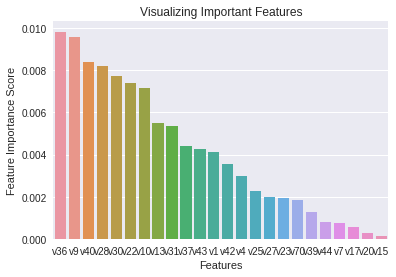

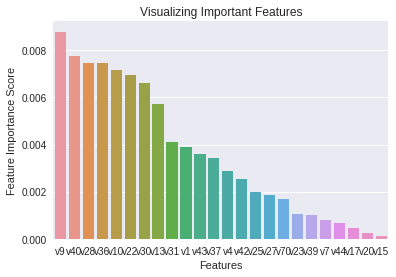

In [0]:
for every_m_f in feature_imp:
    sns.barplot(y=every_m_f[every_m_f.shape[0]//2:], x=every_m_f.index[every_m_f.shape[0]//2:],orient='v')
    # Add labels to your graph
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

### Modifying model based on Importance

In [0]:
#picking top 70% of the important features
non_important_features = feature_imp.any().index.tolist()[int(feature_imp.any().shape[0]*.70):]


impt_fit = lambda x: x.fit(X_train.drop(columns = [target] + non_important_features ).values, X_train[target].values)
impt_predict = lambda x: x.predict(X_test.drop(columns = [target] + non_important_features).values)

# metrics or model evaluation
imp_prediction_metrics = [
    [X_test.shape[0], (X_test[target] != i).sum(), accuracy_score(X_test[target], i) , 
        classification_report(X_test[target], i) ]
  for i in [impt_predict(model) for model in 
            [impt_fit(method) for method in models]
           ]]
print(get_metrics(methods,imp_prediction_metrics))

AttributeError: ignored

In [0]:
print(' Process took {:05.2f} minutes'.format((time.time()-global_start)/60))

 Process took 05.96 minutes
